#**Importing libraries**

In [ ]:
# For Data loading and preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# For Model Training
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import LSTM

#**Loading data**

In [ ]:
data = pd.read_csv('MSFT.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


#**Splitting of Train, Test and Validation data + Data preprocessing + Feature scaling**

In [ ]:
# Note: The train_test_split method won't be used in this case since that'll shuffle the data and we can't afford to do it in case of sequential/timeseries data
# So, we would create our train, test and validation data manually

no_of_entries = len(data)
split_ratio = 0.7

train_data_length = round(no_of_entries * split_ratio)
validation_data_length = no_of_entries - train_data_length

print("\nData length :", no_of_entries)
print("\nTrain data length :", train_data_length)
print("\nValidation data lenth :", validation_data_length)

train_data = data[:train_data_length].iloc[:,:2]
print("\nDate columns' datatype before :", type(train_data['Date'][0]))
train_data['Date'] = pd.to_datetime(train_data['Date']) # Convert the date columns datatype from string to timestamp
print("\nDate columns' datatype before :", type(train_data['Date'][0]))

validation_data = data[train_data_length:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date']) # Convert the date columns datatype from string to timestamp

# Converting the dataframe to numpy array
print("\nTrain data's type before :", type(train_data))
dataset_train = np.reshape(train_data['Open'], (-1, 1))
# When you use reshape(-1, 1) , you are asking numpy to reshape your array with 1 column and as many rows as necessary to accommodate the data.
# This operation will result in a 2D array with a shape (n, 1) , where n is the number of elements in your original array.
print("\nTrain data's type after :", type(dataset_train))
print("\nData after reshaping with numpy :\n", dataset_train)

# Scaling down the data values between (0, 1) [Feature Scaling]
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_train_scaled = scaler.fit_transform(dataset_train)
print("\nData after feature-scaling :\n", dataset_train_scaled)

#===========================IMPORTANT===========================#
# Creatiing X_Train and Y_Train
# Before we proceed note the steps below to create the X_ and Y_ train parameters
# 1. We have train data composed of stock open prices over days
# 2. So, it has 1184 prices corresponding 1184 days
# 3. My aim is to predict the open price of the next day.
# 4. I can use a time step of 50 days.
# 5. I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
# 6. Then predict the price of 51th day; and 51th price will be in y_train data
# 7. Again, i will pick prices from 1 to 51, those will be in X_train data
# 8. Then predict the next days price, 52nd price will be in y_train data
'''See the demo below to understand what's written above:
day_1 day_2 day_3 ... day_50        day_51 (to predict)
70    52    65        54            56
52    65    54    ... 56            59
65    54    56    ... 59            62
...   ...   ...   ... ...           ...
And this is how the whole thing continues. If you see clearly, we are simply using previous 50 days' data to predict the 51th days' data'''
X_train = []
y_train = []
time_step = 50
for i in range(time_step, train_data_length):
    X_train.append(dataset_train_scaled[i-time_step:i, 0])
    y_train.append(dataset_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("\nFeatures (Train data) :\n", X_train)
print("\nOutput (Train data) :\n", y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print("\nFeatures (Train data) after reshaping:\n", X_train)
print("\nOutput (Train data) after reshaping:\n", y_train)


Data length : 9083

Train data length : 6358

Validation data lenth : 2725

Date columns' datatype before : <class 'str'>

Date columns' datatype before : <class 'pandas._libs.tslibs.timestamps.Timestamp'>

Train data's type before : <class 'pandas.core.frame.DataFrame'>

Train data's type after : <class 'numpy.ndarray'>

Data after reshaping with numpy :
 [[ 0.088542]
 [ 0.097222]
 [ 0.100694]
 ...
 [24.200001]
 [24.17    ]
 [24.35    ]]

Data after feature-scaling :
 [[0.00000000e+00]
 [1.46407802e-04]
 [2.04970923e-04]
 ...
 [4.06694207e-01]
 [4.06188172e-01]
 [4.09224279e-01]]

Features (Train data) :
 [[0.00000000e+00 1.46407802e-04 2.04970923e-04 ... 3.66036372e-04
  3.51395592e-04 3.22114032e-04]
 [1.46407802e-04 2.04970923e-04 2.34269350e-04 ... 3.51395592e-04
  3.22114032e-04 3.22114032e-04]
 [2.04970923e-04 2.34269350e-04 1.90330143e-04 ... 3.22114032e-04
  3.22114032e-04 3.22114032e-04]
 ...
 [4.28452953e-01 4.21537377e-01 4.23898776e-01 ... 4.17657908e-01
  4.15465147e-01 

#**Plotting of data**

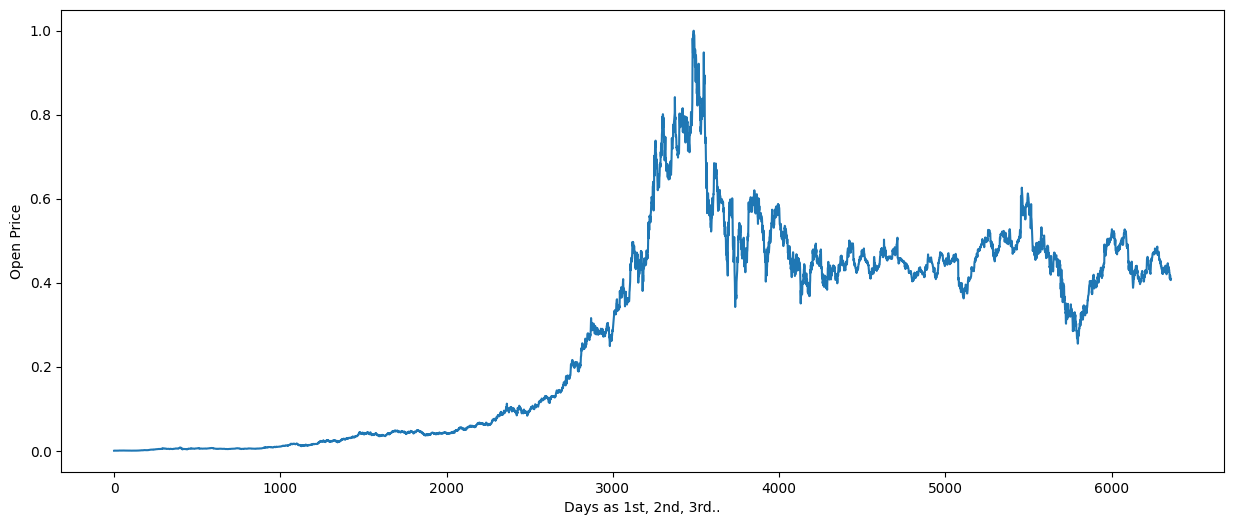

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

#**RNN model**

In [ ]:
# The steps here are similar to the ANN's way of doing things
model = Sequential()

model.add(
  SimpleRNN(units = 50,
            activation = "tanh",
            return_sequences = True,
            input_shape = (X_train.shape[1], 1))
            )
model.add(
    Dropout(0.2)
             )

model.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )
model.add(
    Dropout(0.2)
             )

model.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )
model.add(
    Dropout(0.2)
             )

model.add(
    SimpleRNN(units = 50)
             )
model.add(
    Dropout(0.2)
             )

model.add(Dense(units = 1)) #Output layer

# Mean Squared Error -- Since this is a regression problem
model.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# Validation spit is not done since this a problem of time series and we can't afford to shuffle the data
myModel = model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
198/198 [==============================] - 15s 53ms/step - loss: 0.2052 - accuracy: 0.0000e+00
Epoch 2/50
198/198 [==============================] - 10s 52ms/step - loss: 0.0437 - accuracy: 1.5853e-04
Epoch 3/50
198/198 [==============================] - 12s 61ms/step - loss: 0.0205 - accuracy: 1.5853e-04
Epoch 4/50
198/198 [==============================] - 12s 59ms/step - loss: 0.0122 - accuracy: 1.5853e-04
Epoch 5/50
198/198 [==============================] - 12s 62ms/step - loss: 0.0082 - accuracy: 1.5853e-04
Epoch 6/50
198/198 [==============================] - 12s 63ms/step - loss: 0.0064 - accuracy: 1.5853e-04
Epoch 7/50
198/198 [==============================] - 12s 59ms/step - loss: 0.0048 - accuracy: 1.5853e-04
Epoch 8/50
198/198 [==============================] - 12s 62ms/step - loss: 0.0036 - accuracy: 1.5853e-04
Epoch 9/50
198/198 [==============================] - 12s 63ms/step - loss: 0.0032 - accuracy: 1.5853e-04
Epoch 10/50
198/198 [=========================

#**Predicting & Plotting on Train data**

198/198 [==============================] - 4s 18ms/step


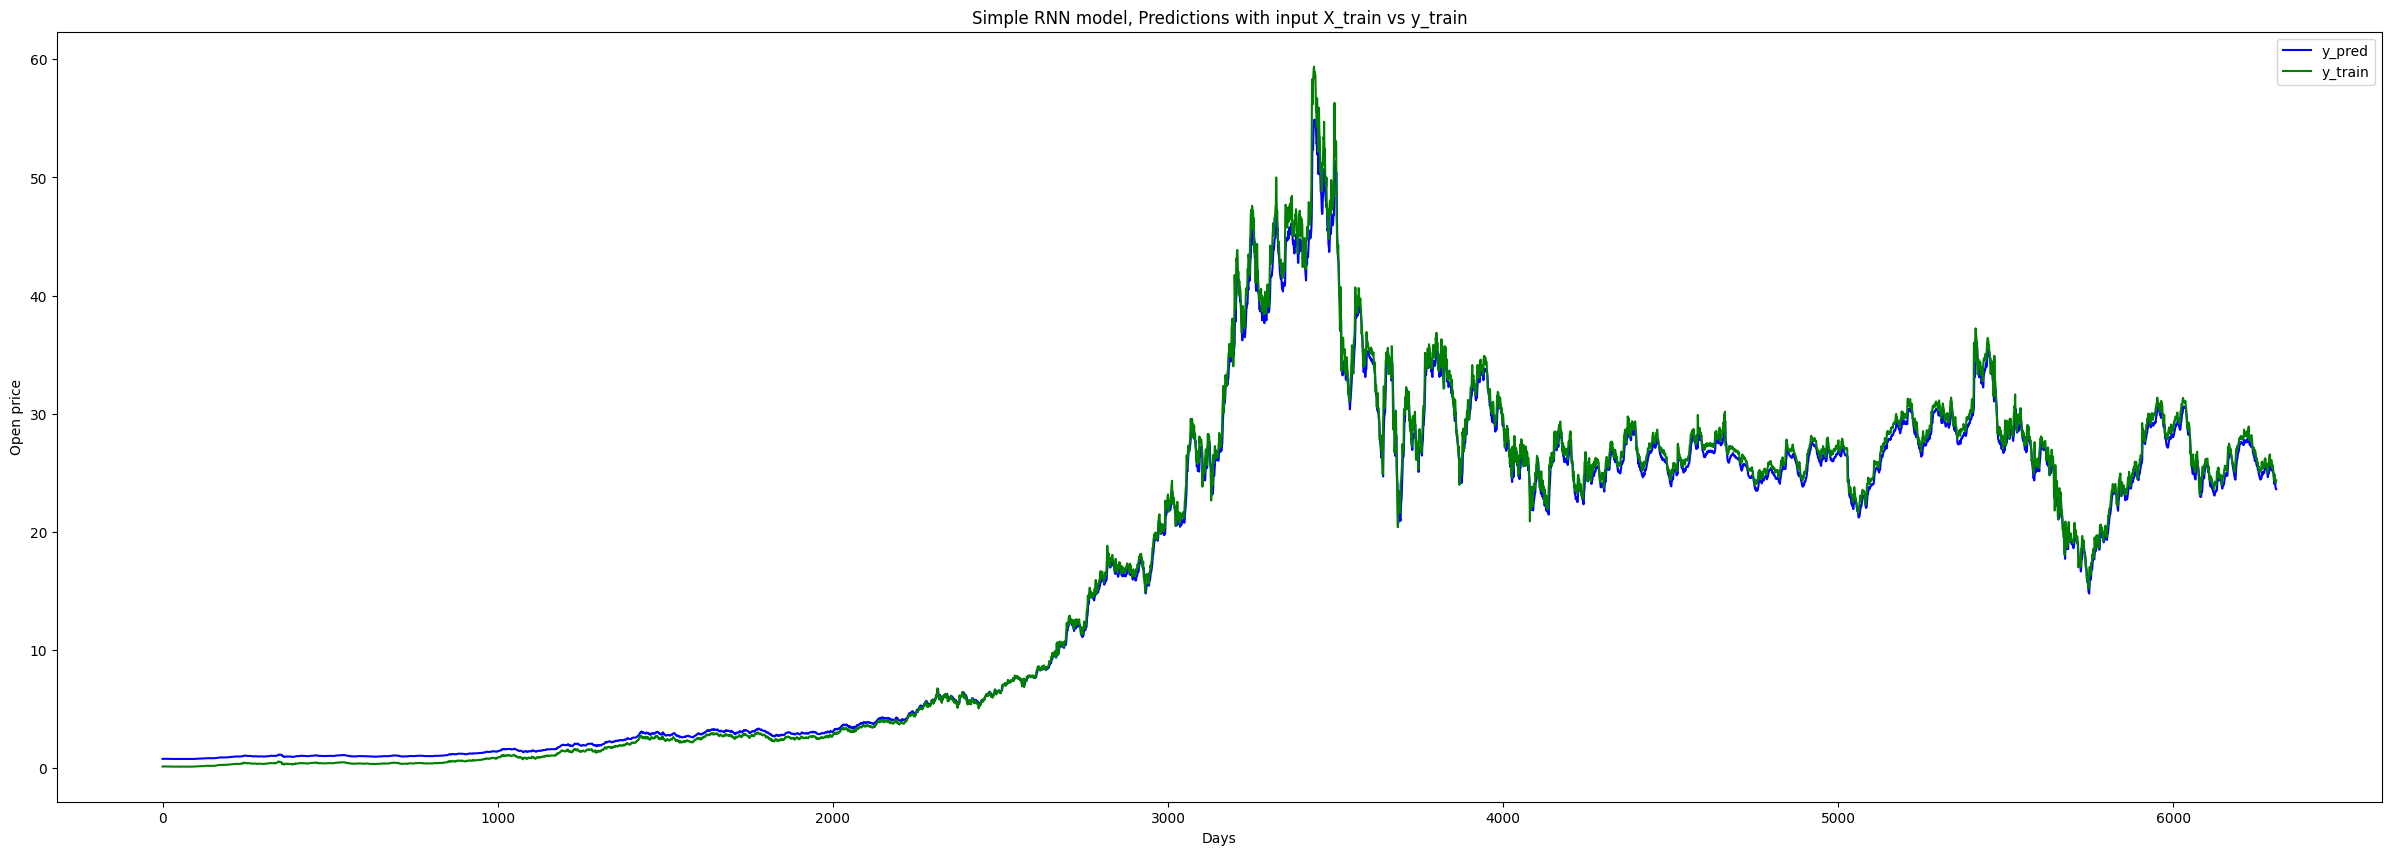

In [ ]:
y_pred = model.predict(X_train)
# scaling back from 0-1 to original
y_pred = scaler.inverse_transform(y_pred)

# scaling back from 0-1 to original
y_train = scaler.inverse_transform(y_train)

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

#**Testing on new set of data**

In [ ]:
# Following the same steps as we did for processing the input data
dataset_validation = validation_data['Open'].values
dataset_validation = np.reshape(dataset_validation, (-1, 1))
scaled_dataset_validation = scaler.fit_transform(dataset_validation)

X_test = []
y_test = []
time_step = 50
for i in range(time_step, validation_data_length):
    X_test.append(scaled_dataset_validation[i-time_step:i, 0])
    y_test.append(scaled_dataset_validation[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
y_test = np.reshape(y_test, (-1, 1))

y_pred_test = model.predict(X_test)
y_pred_of_test = scaler.inverse_transform(y_pred_test)

84/84 [==============================] - 2s 18ms/step


#**Visualizing the Test Data**

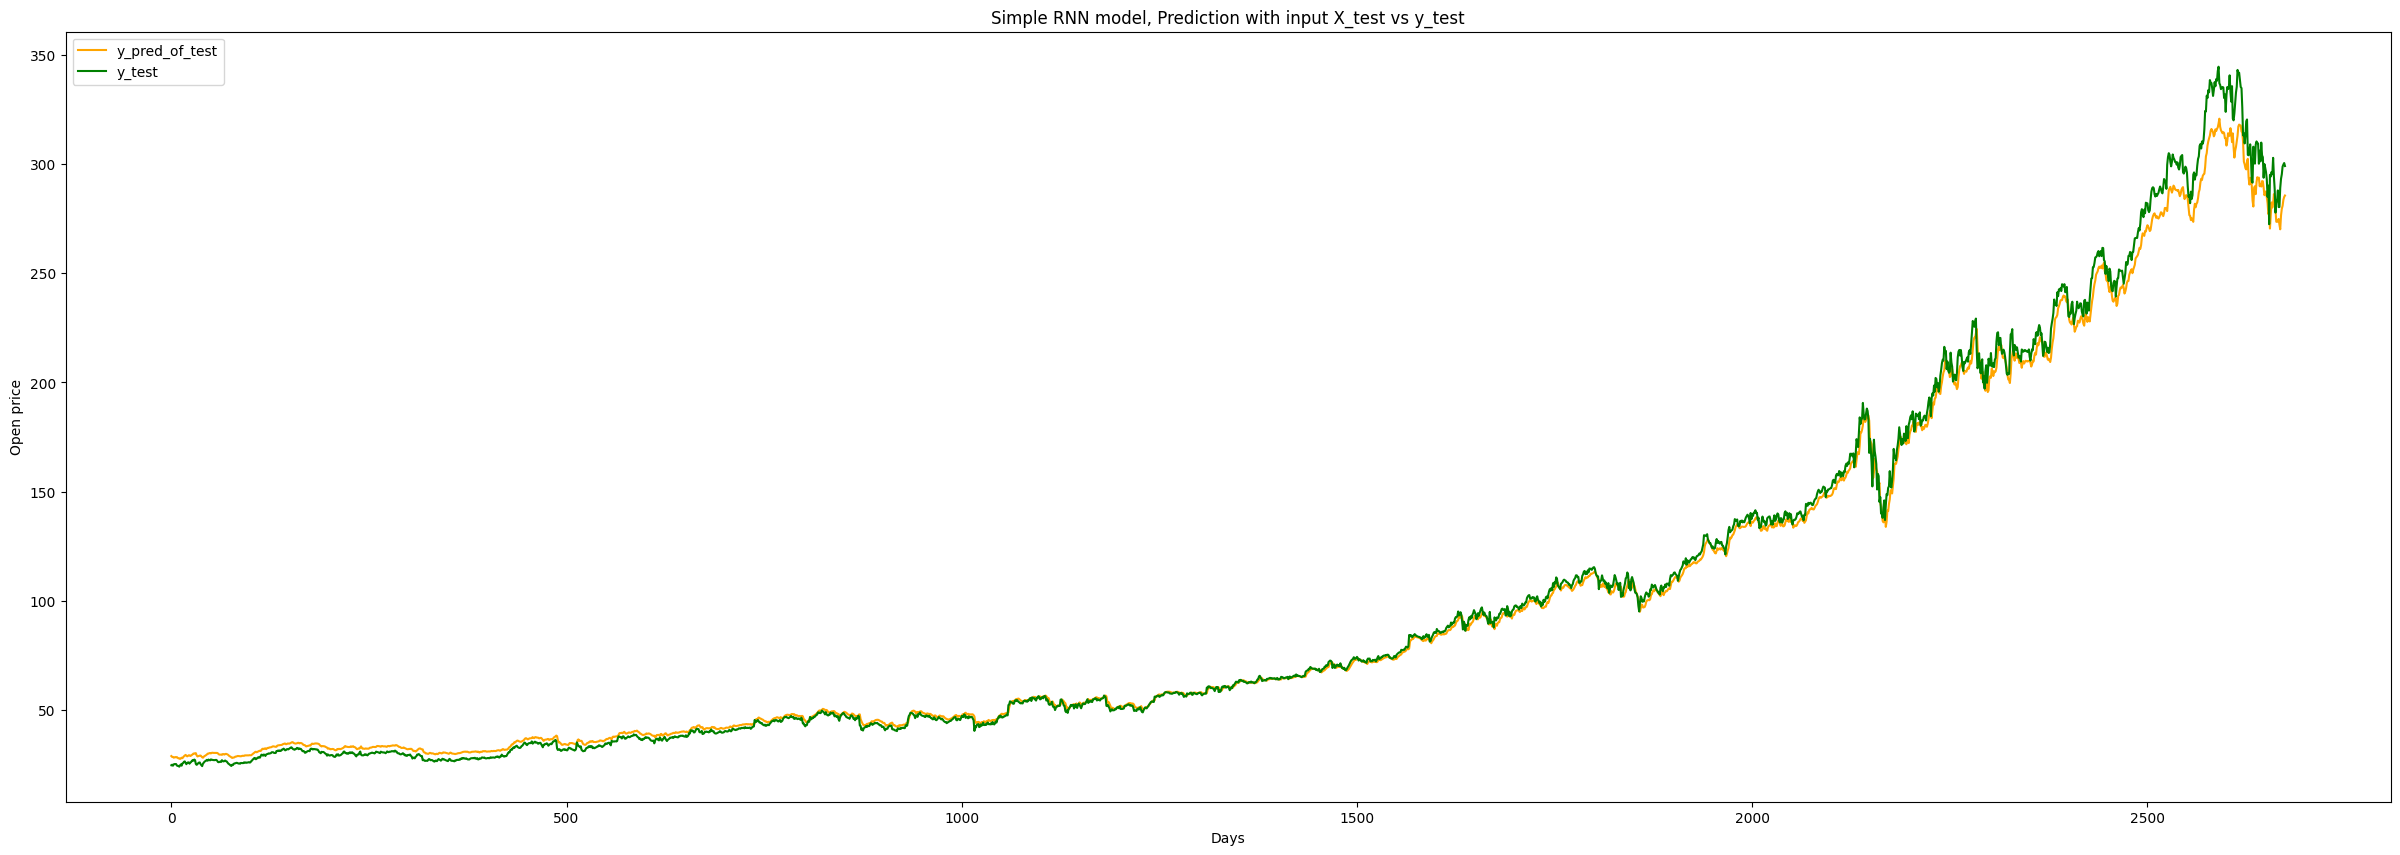

In [ ]:
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

#**Visualizing the whole dataset**

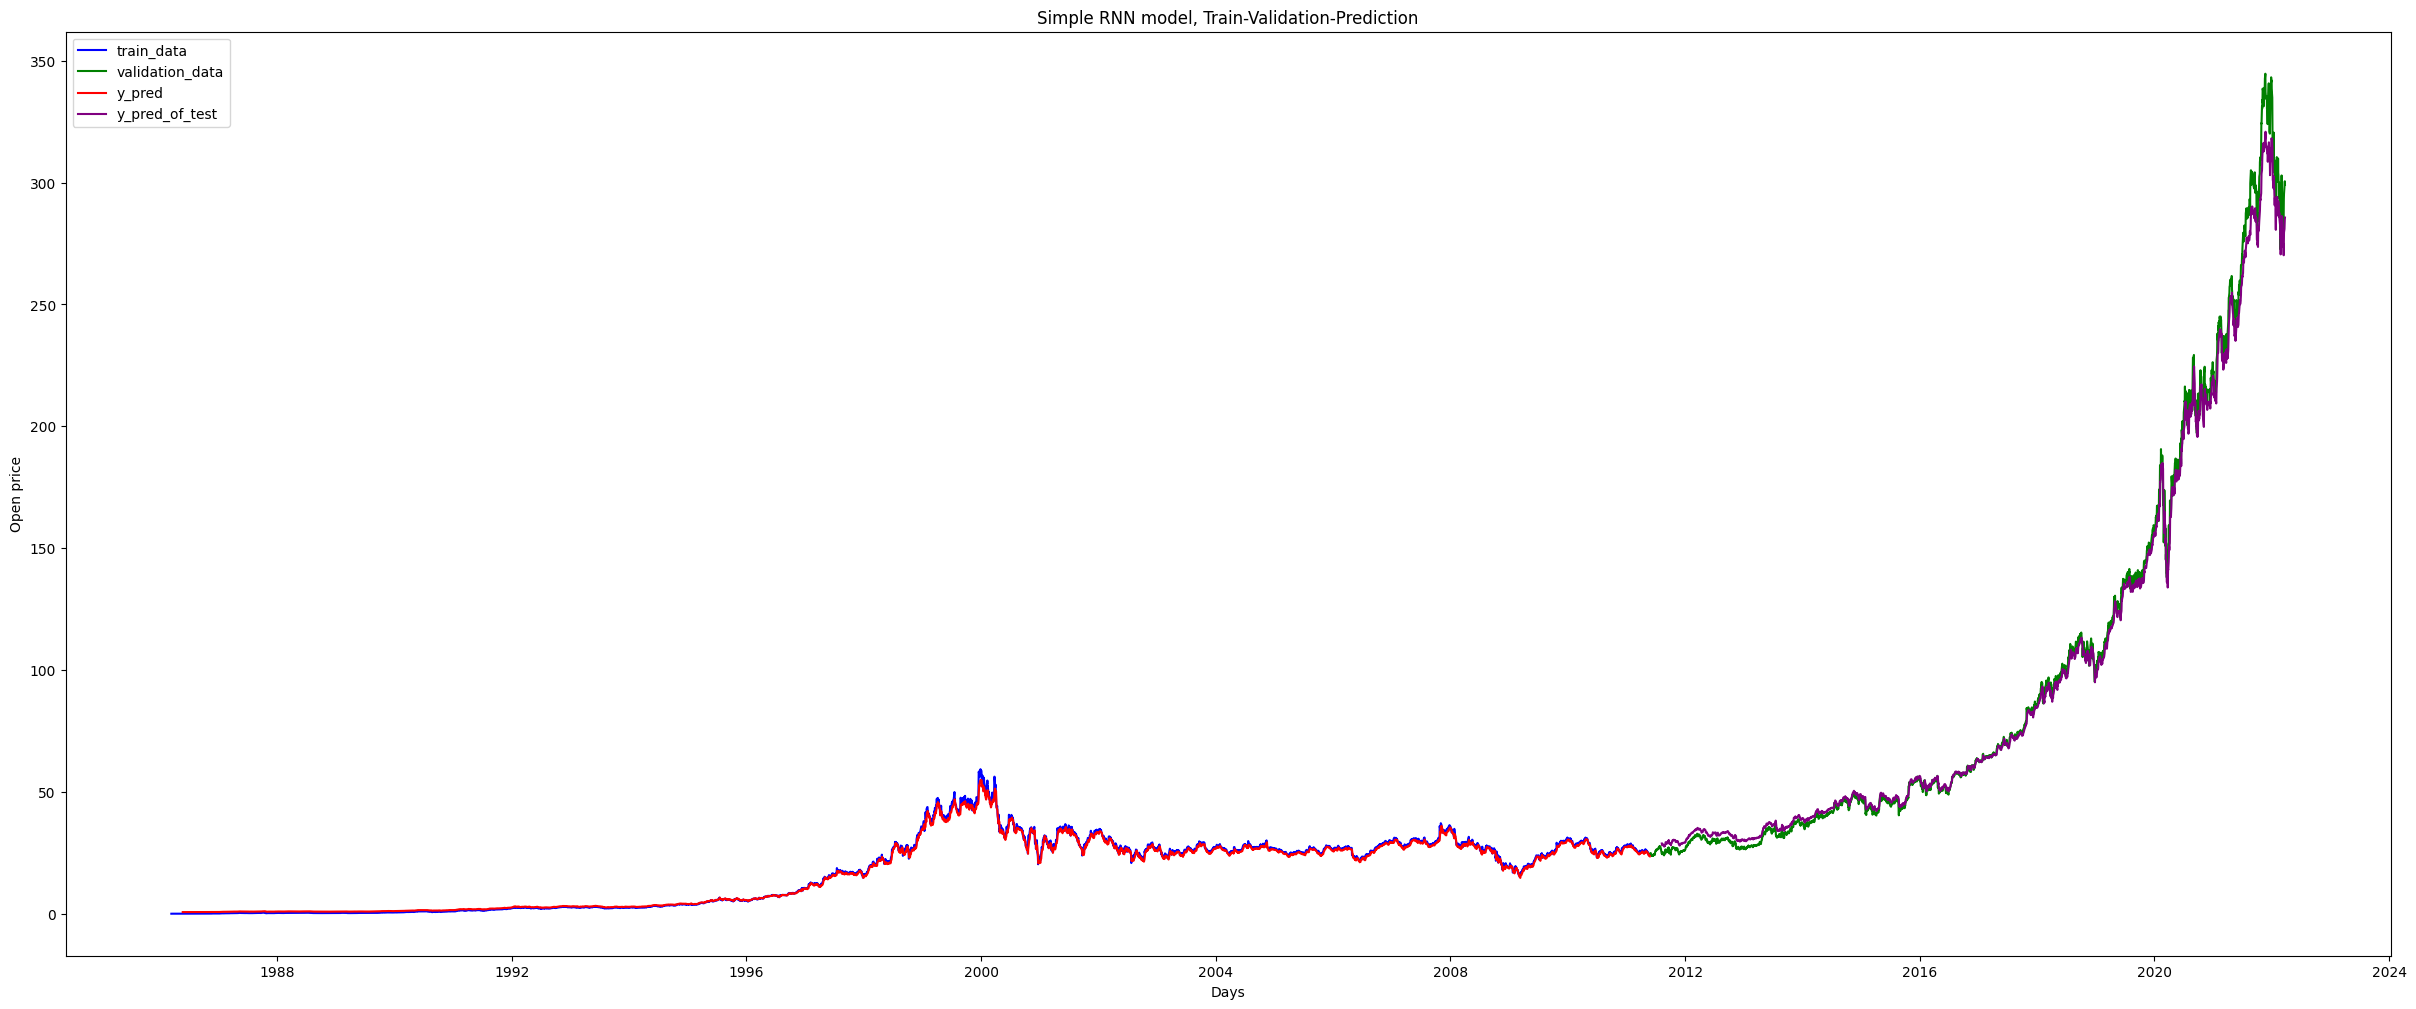

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data['Open'], label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data['Open'], label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "purple")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

#**LSTM RNN model**

In [ ]:
# Until now we did the prediction using RNN only
# Now, let's try the same using LSTM RNN and see how the results vary
y_train = scaler.fit_transform(y_train)

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1], 1)))
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
myModelLSTM = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
631/631 [==============================] - 33s 46ms/step - loss: 0.0012 - accuracy: 4.7559e-04
Epoch 2/10
631/631 [==============================] - 31s 49ms/step - loss: 2.6684e-04 - accuracy: 4.7559e-04
Epoch 3/10
631/631 [==============================] - 31s 49ms/step - loss: 2.4048e-04 - accuracy: 4.7559e-04
Epoch 4/10
631/631 [==============================] - 31s 49ms/step - loss: 2.0181e-04 - accuracy: 4.7559e-04
Epoch 5/10
631/631 [==============================] - 32s 50ms/step - loss: 1.7577e-04 - accuracy: 4.7559e-04
Epoch 6/10
631/631 [==============================] - 31s 50ms/step - loss: 1.4178e-04 - accuracy: 4.7559e-04
Epoch 7/10
631/631 [==============================] - 32s 50ms/step - loss: 1.2015e-04 - accuracy: 4.7559e-04
Epoch 8/10
631/631 [==============================] - 32s 50ms/step - loss: 1.1679e-04 - accuracy: 4.7559e-04
Epoch 9/10
631/631 [==============================] - 31s 50ms/step - loss: 1.0968e-04 - accuracy: 4.7559e-04
Epoch 10/10
63

#**LSTM Prediction Plotting**

84/84 [==============================] - 3s 26ms/step


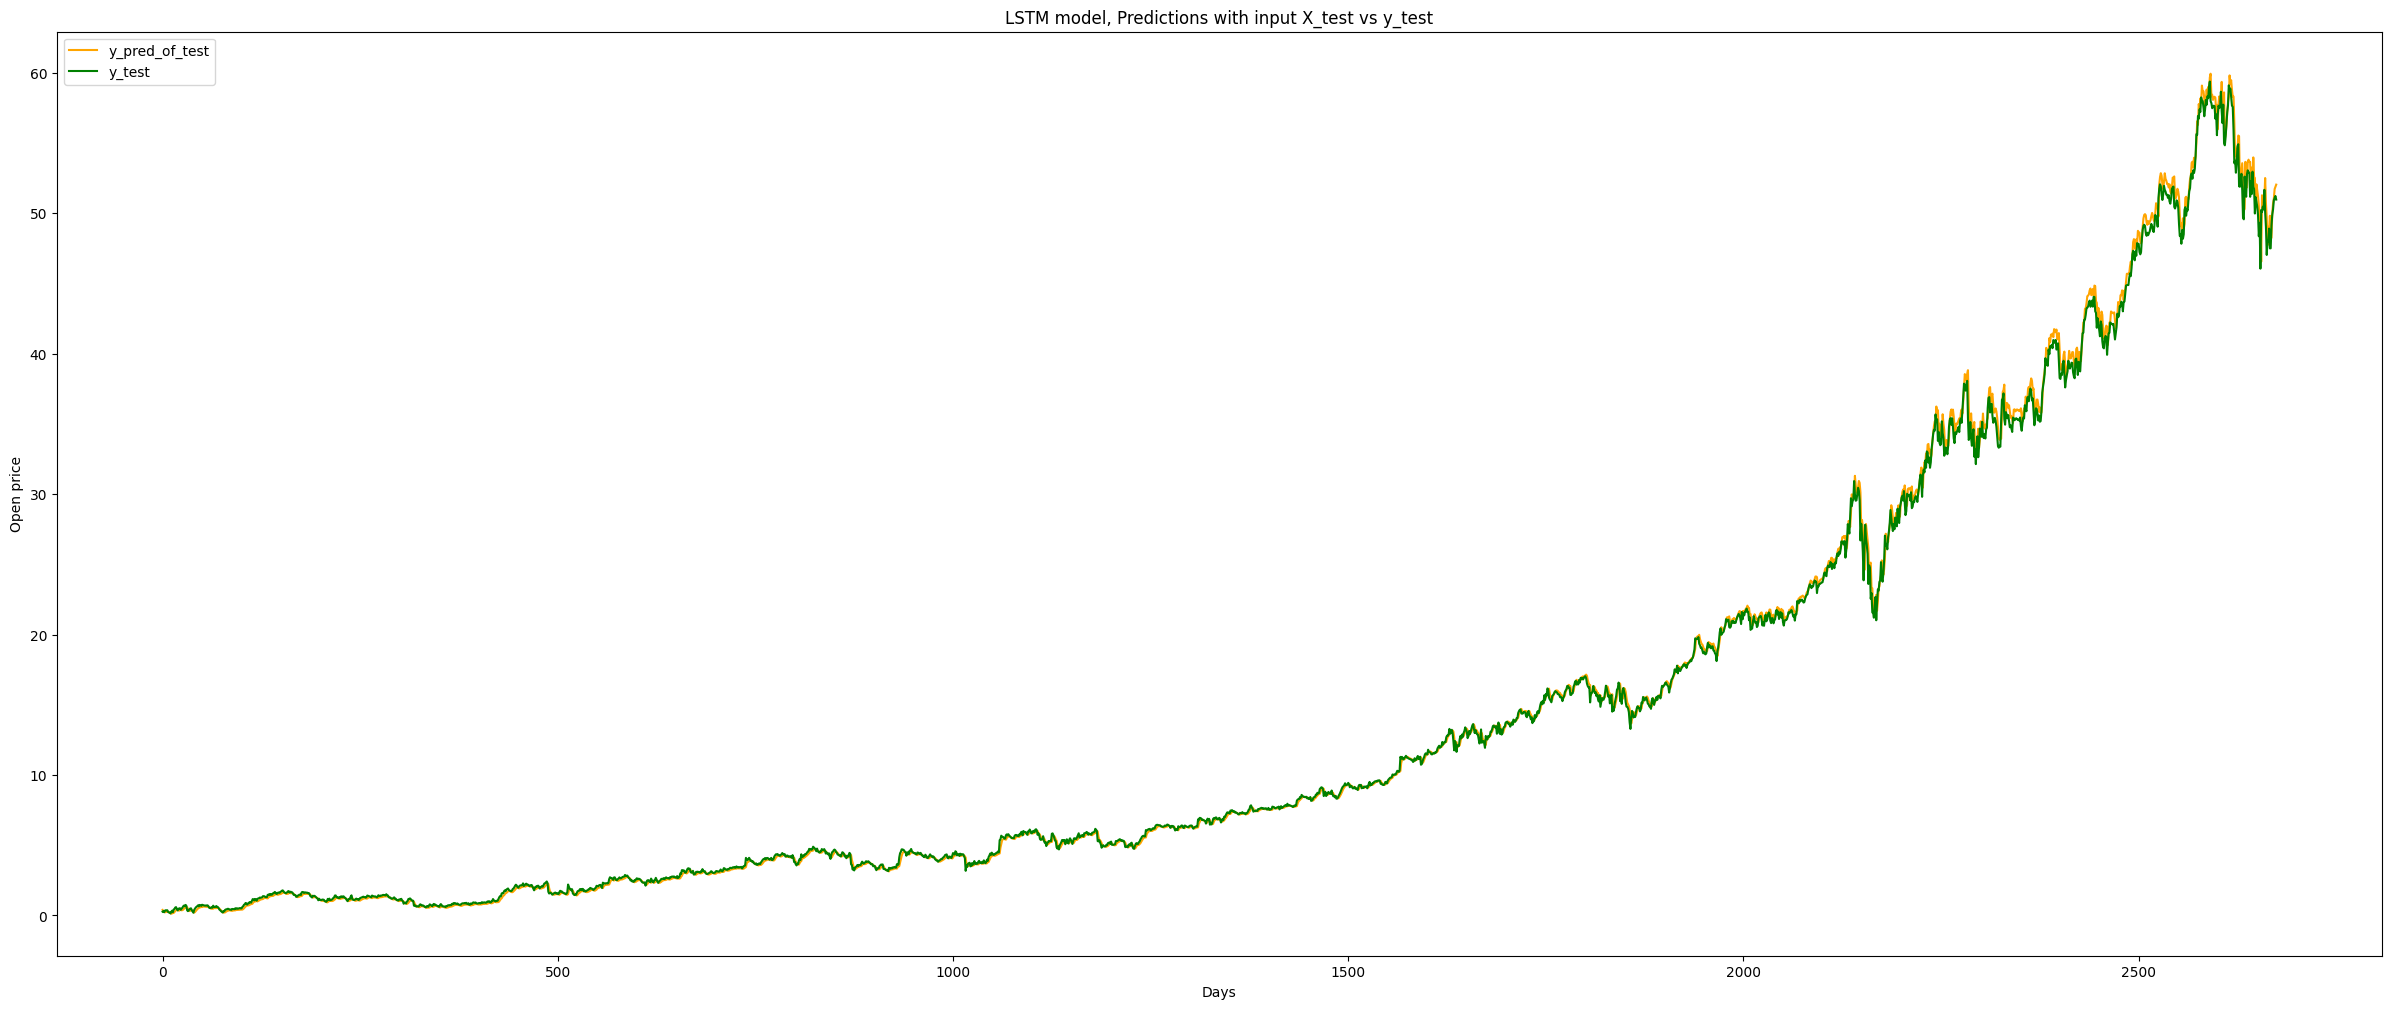

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

#**Future Price Prediction**

In [ ]:
print("\nLast day in our data :", data.iloc[-1])

'''
We can predict the open price for the day after 2022-03-24 --> for 2022-03-25.
We will use last 50 days Open price as input of our model for this prediction
'''
time_step = 50
X_input = data.iloc[-time_step:]['Open'].values
X_input = scaler.fit_transform(X_input.reshape(-1, 1))
X_input = np.reshape(X_input, (1, 50, 1))

simple_RNN_prediction = scaler.inverse_transform(model.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 2022-03-25      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 2022-03-25 :", LSTM_prediction[0,0])


Last day in our data : Date         2022-03-24
Open         299.140015
High         304.200012
Low          298.320007
Close        304.100006
Adj Close    304.100006
Volume         24446900
Name: 9082, dtype: object
1/1 [==============================] - 0s 52ms/step
Simple RNN, Open price prediction for 2022-03-25      : 298.27072
LSTM prediction, Open price prediction for 2022-03-25 : 299.93637
